In [1]:
import os
import tensorflow as tf
import pandas
from pandas import read_csv
import numpy as np
import math

from keras.optimizers import SGD
from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.applications import imagenet_utils
import h5py as h5py
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import initializers
from keras.models import Sequential, Model

from __future__ import division

from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import matplotlib.pyplot as plt

# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))


Using TensorFlow backend.


Downloading the weights:

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2018-06-23 17:09:44--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.216.176, 2607:f8b0:4005:80b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.216.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  71.2MB/s    in 1.2s    

2018-06-23 17:09:45 (71.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(256, 256, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called mixed7. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from mixed7:

In [7]:
last_layer = pre_trained_model.get_layer('mixed7')
print 'last layer output shape:', last_layer.output_shape
last_output = last_layer.output
last_output = GlobalAveragePooling2D()(last_output)


last layer output shape: (None, 14, 14, 768)


Now let's stick a fully connected classifier on top of last_output:

In [7]:
#STEP DECAY LEARNING RATE (LEARNINGG RATE SCHEDULER)
def step_decay(epoch):
   initial_lrate = 0.0001
   drop = 0.5
   epochs_drop = 7.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = last_output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

# Configure and compile the model
#model = Model(pre_trained_model.input, x)
#rmsprop = RMSprop(lr=0.0, rho=0.9, epsilon=None, decay=0.0)
#model.compile(loss='binary_crossentropy',
 #             optimizer=rmsprop,
  #            metrics=['acc'])



# Configure and compile the model
model = Model(inputs=pre_trained_model.input, outputs=x)


In [12]:

# /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
model.load_weights("/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

ValueError: You are trying to load a weight file containing 188 layers into a model with 142 layers.

In [9]:
import os
import zipfile

# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
# base_dir = '/tmp/cats_and_dogs_filtered'
base_dir = '/mnt/data/datasets/tvt1182'

train_dir = os.path.join(base_dir, 'chnmcu256train')
validation_dir = os.path.join(base_dir, 'chnmcu256validate')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'Normal')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'TB')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'Normal')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'TB')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)


from keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

train_datagen = ImageDataGenerator(
    rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(256, 256),  # All images will be resized to 256x256
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        # All images will be resized to 256x256
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')



Found 94472 images belonging to 2 classes.
Found 19600 images belonging to 2 classes.


Finally, let's train the model using the features we extracted. We'll train on all 94472 images available, for 30 epochs, and validate on all 19600 test images

In [10]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list,
      verbose=2)

Epoch 1/30
 - 10s - loss: 0.6272 - acc: 0.6515 - val_loss: 0.6377 - val_acc: 0.5890
Epoch 2/30
 - 7s - loss: 0.5096 - acc: 0.7820 - val_loss: 0.5720 - val_acc: 0.7170
Epoch 3/30
 - 7s - loss: 0.4523 - acc: 0.8270 - val_loss: 0.4844 - val_acc: 0.8410
Epoch 4/30
 - 7s - loss: 0.4009 - acc: 0.8540 - val_loss: 0.4497 - val_acc: 0.8560
Epoch 5/30
 - 7s - loss: 0.3883 - acc: 0.8465 - val_loss: 0.3864 - val_acc: 0.8780
Epoch 6/30
 - 7s - loss: 0.3560 - acc: 0.8562 - val_loss: 0.3898 - val_acc: 0.8630
Epoch 7/30
 - 7s - loss: 0.3547 - acc: 0.8595 - val_loss: 0.3194 - val_acc: 0.8880
Epoch 8/30
 - 7s - loss: 0.3287 - acc: 0.8705 - val_loss: 0.3040 - val_acc: 0.8950
Epoch 9/30
 - 7s - loss: 0.3143 - acc: 0.8820 - val_loss: 0.2940 - val_acc: 0.8970
Epoch 10/30
 - 7s - loss: 0.3327 - acc: 0.8610 - val_loss: 0.2817 - val_acc: 0.8960
Epoch 11/30
 - 7s - loss: 0.3177 - acc: 0.8820 - val_loss: 0.2894 - val_acc: 0.8960
Epoch 12/30
 - 7s - loss: 0.3061 - acc: 0.8935 - val_loss: 0.2955 - val_acc: 0.8940


**Further Improving Accuracy with Fine-Tuning**

**In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:
•Fine-tuning should only be attempted after you have trained the top-level classifier with the pretrained model set to non-trainable. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
•Additionally, we fine-tune only the top layers of the pre-trained model rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.**

**All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the mixed7 module—i.e., all layers found after mixed6—and recompile the model:**


In [11]:
unfreeze = True

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

from keras.optimizers import SGD

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [12]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list,
      verbose=2)

Epoch 1/50
 - 18s - loss: 0.2780 - acc: 0.8955 - val_loss: 0.4125 - val_acc: 0.8300
Epoch 2/50
 - 15s - loss: 0.2804 - acc: 0.8900 - val_loss: 0.3071 - val_acc: 0.8910
Epoch 3/50
 - 15s - loss: 0.2555 - acc: 0.9045 - val_loss: 0.4154 - val_acc: 0.8450
Epoch 4/50
 - 15s - loss: 0.2418 - acc: 0.9080 - val_loss: 0.2826 - val_acc: 0.8940
Epoch 5/50
 - 15s - loss: 0.2453 - acc: 0.9075 - val_loss: 0.2451 - val_acc: 0.9140
Epoch 6/50
 - 15s - loss: 0.2365 - acc: 0.9120 - val_loss: 0.3108 - val_acc: 0.8820
Epoch 7/50
 - 15s - loss: 0.2137 - acc: 0.9185 - val_loss: 0.2848 - val_acc: 0.8870
Epoch 8/50
 - 15s - loss: 0.2093 - acc: 0.9190 - val_loss: 0.3074 - val_acc: 0.8900
Epoch 9/50
 - 15s - loss: 0.1999 - acc: 0.9250 - val_loss: 0.2404 - val_acc: 0.9140
Epoch 10/50
 - 15s - loss: 0.1810 - acc: 0.9385 - val_loss: 0.2593 - val_acc: 0.9030
Epoch 11/50
 - 15s - loss: 0.2032 - acc: 0.9220 - val_loss: 0.2556 - val_acc: 0.9090
Epoch 12/50
 - 15s - loss: 0.1931 - acc: 0.9345 - val_loss: 0.2906 - val_a

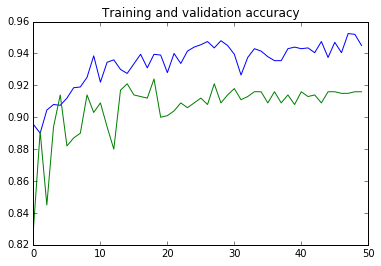

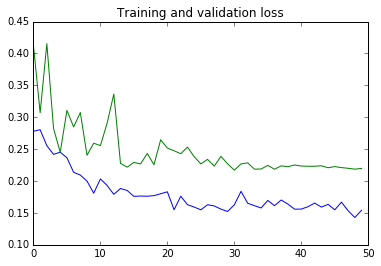

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [16]:
from keras.models import load_model

model.save('tb_model.h5')  # creates a HDF5 file 'tb_model.h5'
del model  # deletes the existing model

Found 200 images belonging to 2 classes.
200/200 [==============================] - 5s 24ms/step
             precision    recall  f1-score   support

    Healthy       0.93      0.95      0.94       100
         TB       0.95      0.93      0.94       100

avg / total       0.94      0.94      0.94       200



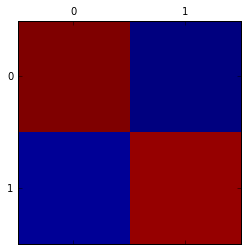

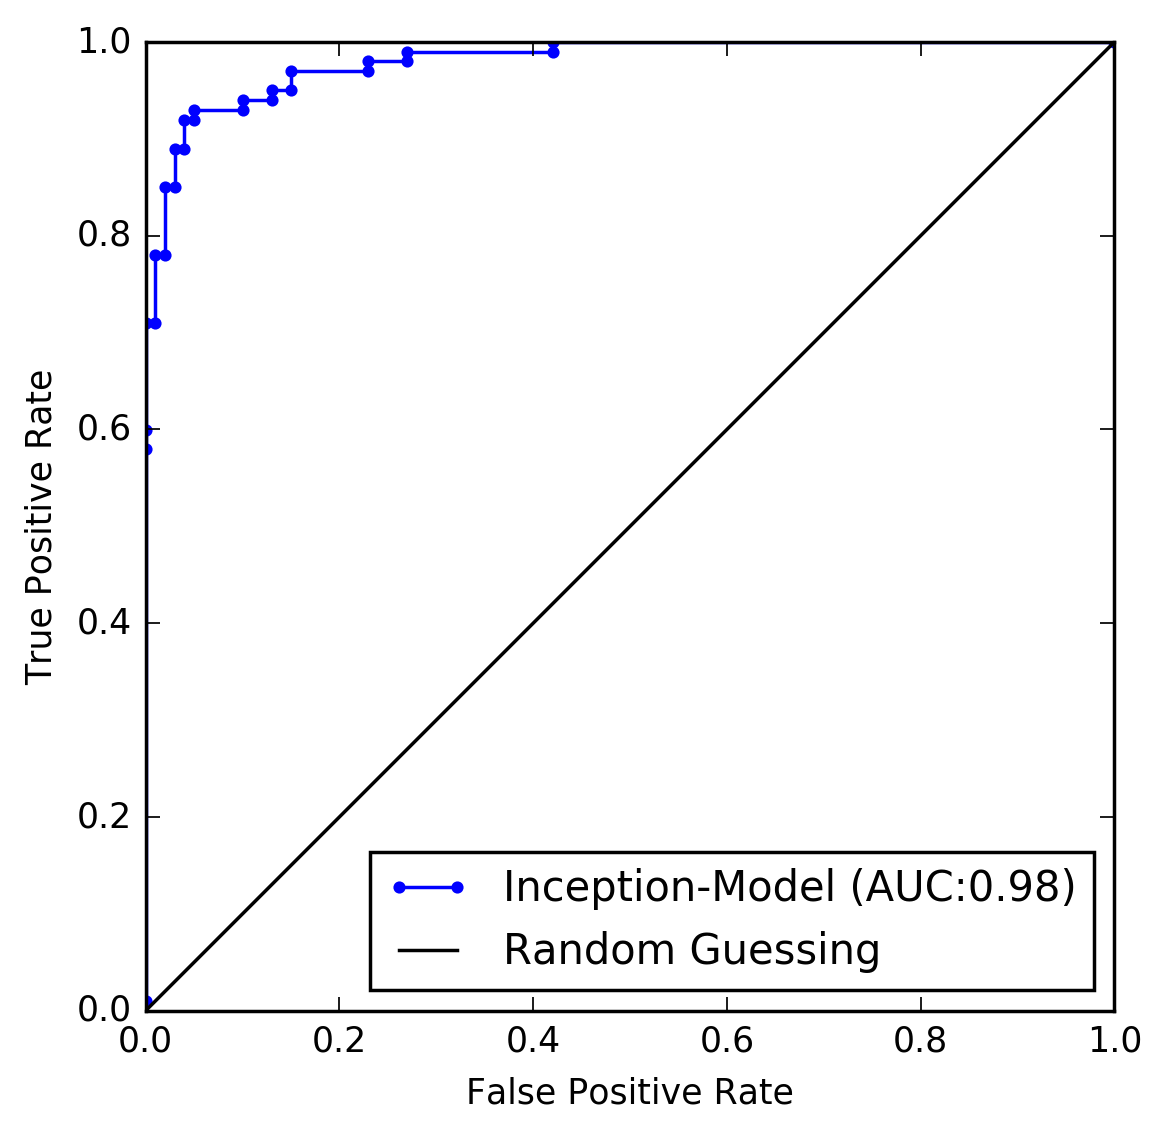

In [17]:
model = load_model('tb_model.h5')
test_dir = os.path.join(base_dir, 'chnmcu256test')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')


Found 100 images belonging to 2 classes.
100/100 [==============================] - 2s 16ms/step
             precision    recall  f1-score   support

    Healthy       1.00      1.00      1.00        50
         TB       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       100



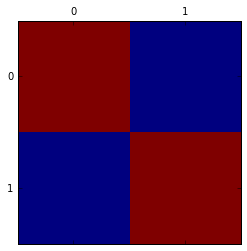

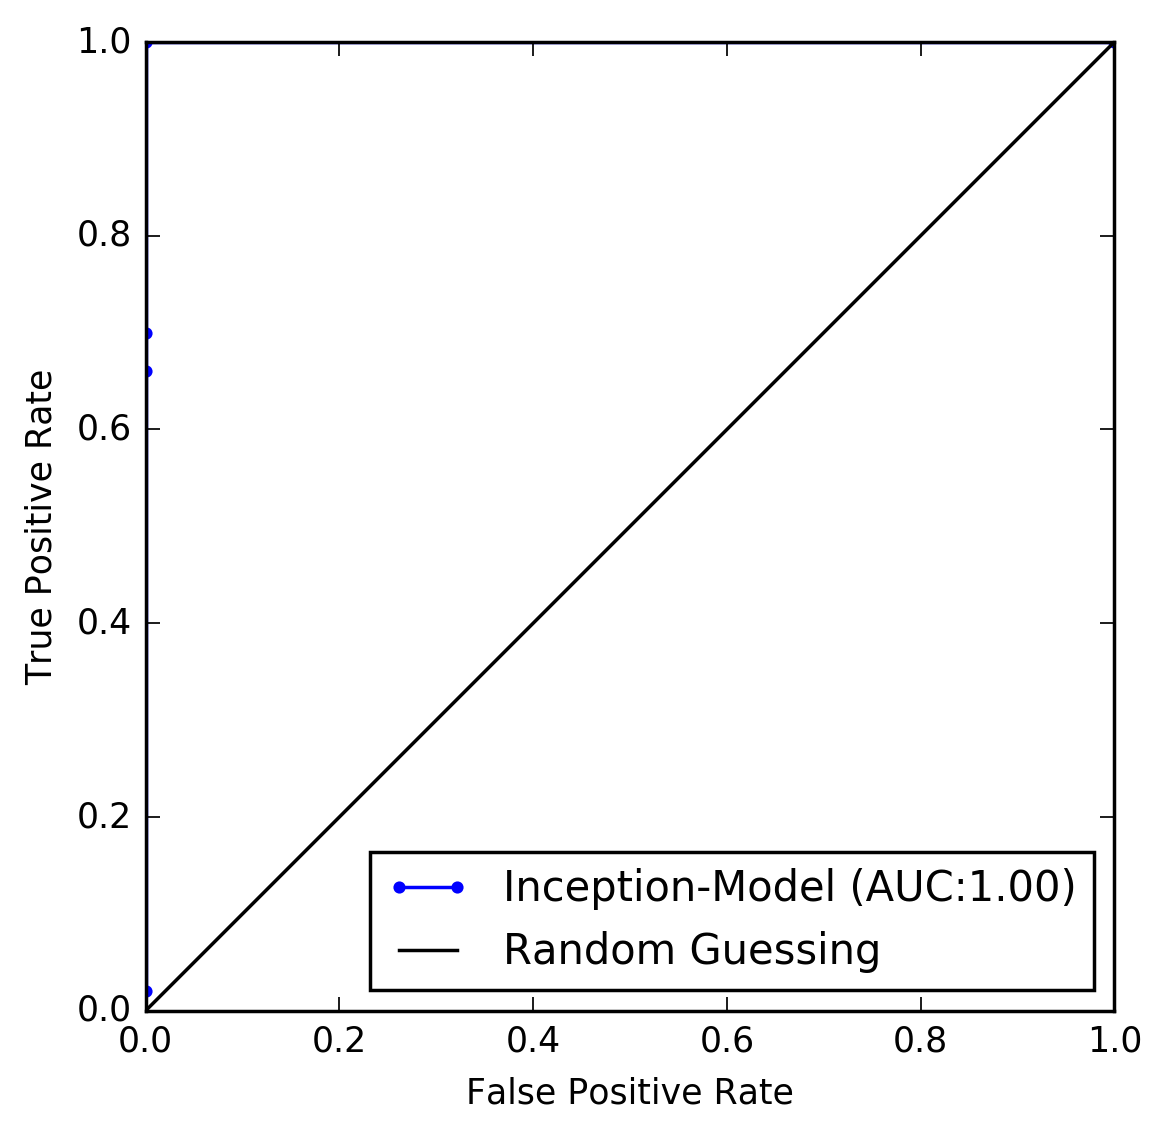

In [18]:
test_dir = os.path.join(base_dir, 'chnmcu256test')
test_dir = '/mnt/data/datasets/belnormtvt/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=671,
        class_mode='binary')

test_X, test_Y = next(test_generator)

pred_Y = model.predict(test_X, batch_size = 1, verbose = True)

from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'Inception-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')
